# 1. Distance Map

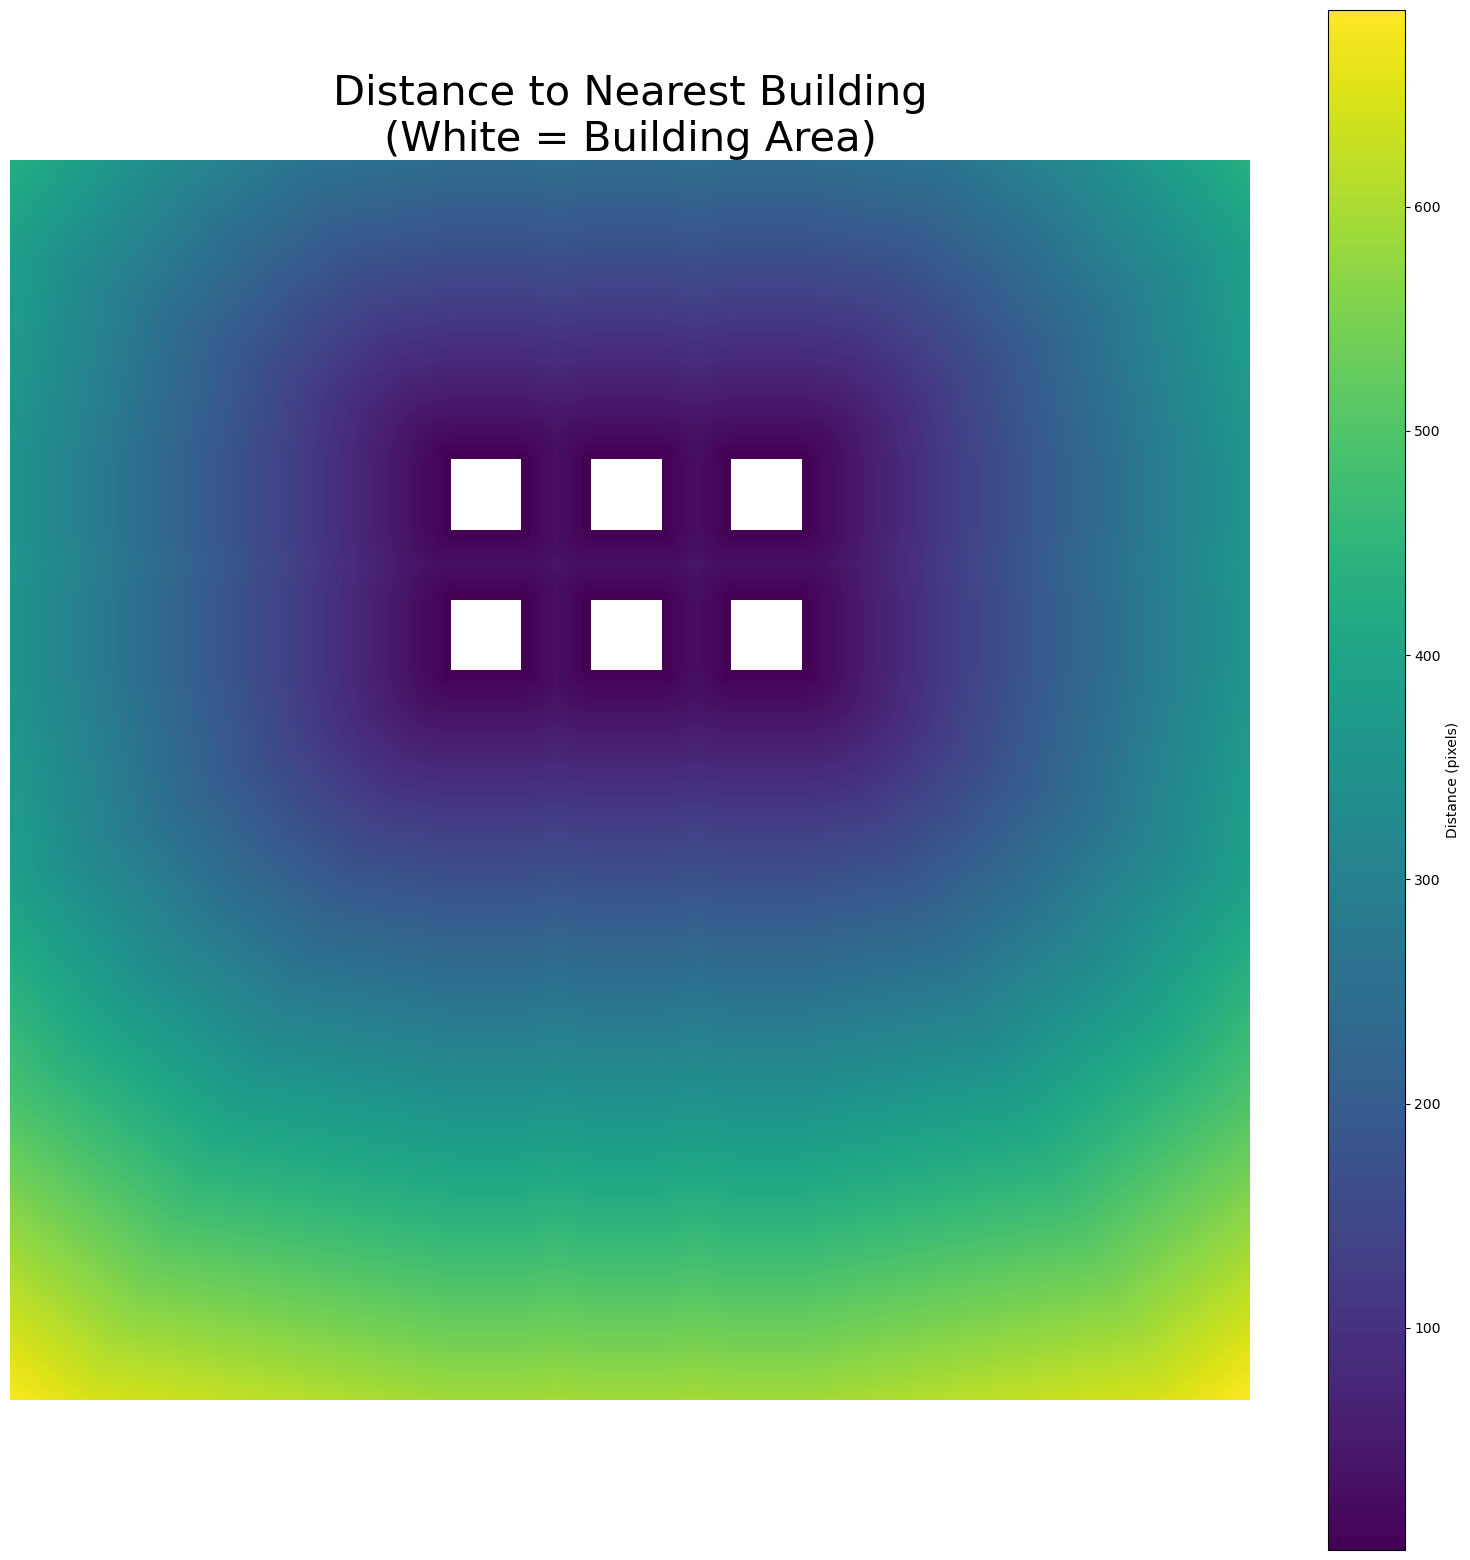

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. Load and preprocess the image ---
# Load image and convert to RGB array
img = np.array(Image.open(r"..\RawSimOutputData\6Bldgs\BldgMask150cm.png").convert("RGB"))

# Identify building pixels (pure red areas)
red_mask = (img[:, :, 0] > 200) & (img[:, :, 1] < 50) & (img[:, :, 2] < 50)

# Invert for distance transform: 1 where non-building (background), 0 where building
non_building_mask = (~red_mask).astype(np.uint8)

# --- 2. Compute Euclidean distance transform ---
dist_transform = cv2.distanceTransform(non_building_mask, distanceType=cv2.DIST_L2, maskSize=5)

# --- 3. Set distance = NaN in building pixels ---
dist_transform_nan = dist_transform.astype(float)
dist_transform_nan[red_mask] = np.nan

# --- 4. Visualization ---
plt.figure(figsize=(20, 20))
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')  # NaNs appear white

plt.imshow(dist_transform_nan, cmap=cmap)
plt.title("Distance to Nearest Building\n(White = Building Area)",fontsize=30)
plt.axis("off")
plt.colorbar(label="Distance (pixels)")
plt.show()


# 2. Video Data Processing

In [2]:
import cv2
import os
from glob import glob

# Path to the folder containing your videos
video_folder = r"..\RawSimOutputData\6Bldgs\Videos"
output_folder = r"..\data\Y"

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Process each .mp4 video in the folder
video_files = glob(os.path.join(video_folder, "*.mp4"))

for video_path in video_files:
    # Extract the filename without extension
    base_name = os.path.splitext(os.path.basename(video_path))[0]
    
    # Open the video
    cap = cv2.VideoCapture(video_path)
    frame_number = 1
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        continue
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # This must not be commented out!

        # Construct output filename
        output_filename = f"{base_name}_{frame_number}.png"
        output_path = os.path.join(output_folder, output_filename)

        # Save the frame as PNG
        cv2.imwrite(output_path, frame)
        print(f"Saved {os.path.abspath(output_path)}")
        print(f"Output folder is: {os.path.abspath(output_folder)}")

        frame_number += 1
        if frame is None:
            print(f"Frame {frame_number} in {base_name} is None")
            break
        else:
            print(f"Read frame {frame_number} from {base_name} with shape {frame.shape}")
    cap.release()
    print(f"Extracted {frame_number - 1} frames from {base_name}")

print("Done.")


Saved c:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\Y\2024-03-17_6Bldgs_AT_286-293K_1.png
Output folder is: c:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\Y
Read frame 2 from 2024-03-17_6Bldgs_AT_286-293K with shape (1000, 1000, 3)
Saved c:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\Y\2024-03-17_6Bldgs_AT_286-293K_2.png
Output folder is: c:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\Y
Read frame 3 from 2024-03-17_6Bldgs_AT_286-293K with shape (1000, 1000, 3)
Saved c:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\Y\2024-03-17_6Bldgs_AT_286-293K_3.png
Output folder is: c:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\Y
Read frame 4 from 2024-03-17_6Bldgs_AT_286-293K with shape (1000, 1000, 3)
Saved c:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\Y\2024-03-17_6Bldgs_AT_286-293K_4.png
Output folder is: c:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\Y
Read frame 5 from 2024-03-17_6Bldgs_AT_286-293K with shape (1000, 1000, 3)
Save

# 3. Sim Input Data for each Timestep

5values Winddir, speed, air temp, solar rad, hour

In [3]:
import os
import pandas as pd
from glob import glob

# Paths
csv_folder = "../SimulationInputs/FinalSimulationInputs"
output_folder = os.path.abspath(os.path.join(csv_folder, "../../data/X"))
os.makedirs(output_folder, exist_ok=True)

# Get all unique dates
csv_files = glob(os.path.join(csv_folder, "*.csv"))
dates = sorted(set(os.path.basename(f).split("_")[0] for f in csv_files))

for date in dates:
    try:
        print(f"⏳ Processing {date}...")

        # Load data
        wind_dir = pd.read_csv(os.path.join(csv_folder, f"{date}_wind_direction_hourly.csv"))
        wind_dir = wind_dir["Wind Direction (deg)"].reset_index(drop=True)

        wind_speed = pd.read_csv(os.path.join(csv_folder, f"{date}_wind_speed_hourly.csv"), skiprows=3)
        solar = pd.read_csv(os.path.join(csv_folder, f"{date}_solar_irradiance_hourly.csv"), skiprows=3)
        temp = pd.read_csv(os.path.join(csv_folder, f"{date}_temperature_hourly.csv"), skiprows=3)

        # Sanity check
        assert len(wind_dir) >= 24, f"{date} wind direction too short"
        assert len(wind_speed) >= 25, f"{date} windspeed too short"
        assert len(solar) >= 25, f"{date} solar too short"
        assert len(temp) >= 25, f"{date} temp too short"

        for i in range(1, 25):  # Hours 1 to 24
            hour_str = f"{i:02d}"

            wind_speed_val = float(wind_speed["windspeed"].iloc[i])
            solar_val = float(solar["irradiation"].iloc[i])
            temp_val = float(temp["temperature"].iloc[i])

            # Wind direction: use iloc[i] for 1–23, use last value (23) for hour 24
            wind_dir_val = float(wind_dir.iloc[i]) if i < 24 else float(wind_dir.iloc[23])

            df = pd.DataFrame([{
                "Hour": i,
                "Windspeed (m/s)": wind_speed_val,
                "Wind Direction (deg)": wind_dir_val,
                "Solar Irradiance (W/m2)": solar_val,
                "Air Temperature (K)": temp_val,
            }])

            filename = f"5values_{date}_{hour_str}.csv"
            df.to_csv(os.path.join(output_folder, filename), index=False)

        print(f"✅ Saved 24 hourly CSVs for {date}")

    except Exception as e:
        print(f"❌ Failed to process {date}: {e}")

print("🏁 All done.")

⏳ Processing 2024-03-17...
✅ Saved 24 hourly CSVs for 2024-03-17
⏳ Processing 2024-03-24...
✅ Saved 24 hourly CSVs for 2024-03-24
⏳ Processing 2024-04-01...
✅ Saved 24 hourly CSVs for 2024-04-01
⏳ Processing 2024-04-12...
✅ Saved 24 hourly CSVs for 2024-04-12
⏳ Processing 2024-04-23...
✅ Saved 24 hourly CSVs for 2024-04-23
⏳ Processing 2024-05-24...
✅ Saved 24 hourly CSVs for 2024-05-24
⏳ Processing 2024-05-29...
✅ Saved 24 hourly CSVs for 2024-05-29
⏳ Processing 2024-06-08...
✅ Saved 24 hourly CSVs for 2024-06-08
⏳ Processing 2024-06-10...
✅ Saved 24 hourly CSVs for 2024-06-10
⏳ Processing 2024-06-21...
✅ Saved 24 hourly CSVs for 2024-06-21
⏳ Processing 2024-07-20...
✅ Saved 24 hourly CSVs for 2024-07-20
⏳ Processing 2024-07-31...
✅ Saved 24 hourly CSVs for 2024-07-31
🏁 All done.


# Winddirection mask

each pixel is weighted by wind_direction_vector X inverse_distance.

idea is to weight each pixel’s proximity to buildings by wind direction, to give the model a sense of upstream vs downstream

	•	Pixels behind buildings (relative to wind) are highlighted.


✅ Inverse distance mask saved to C:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\X\DistanceMask
✅ 360 wake masks written to C:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\X\WindMask


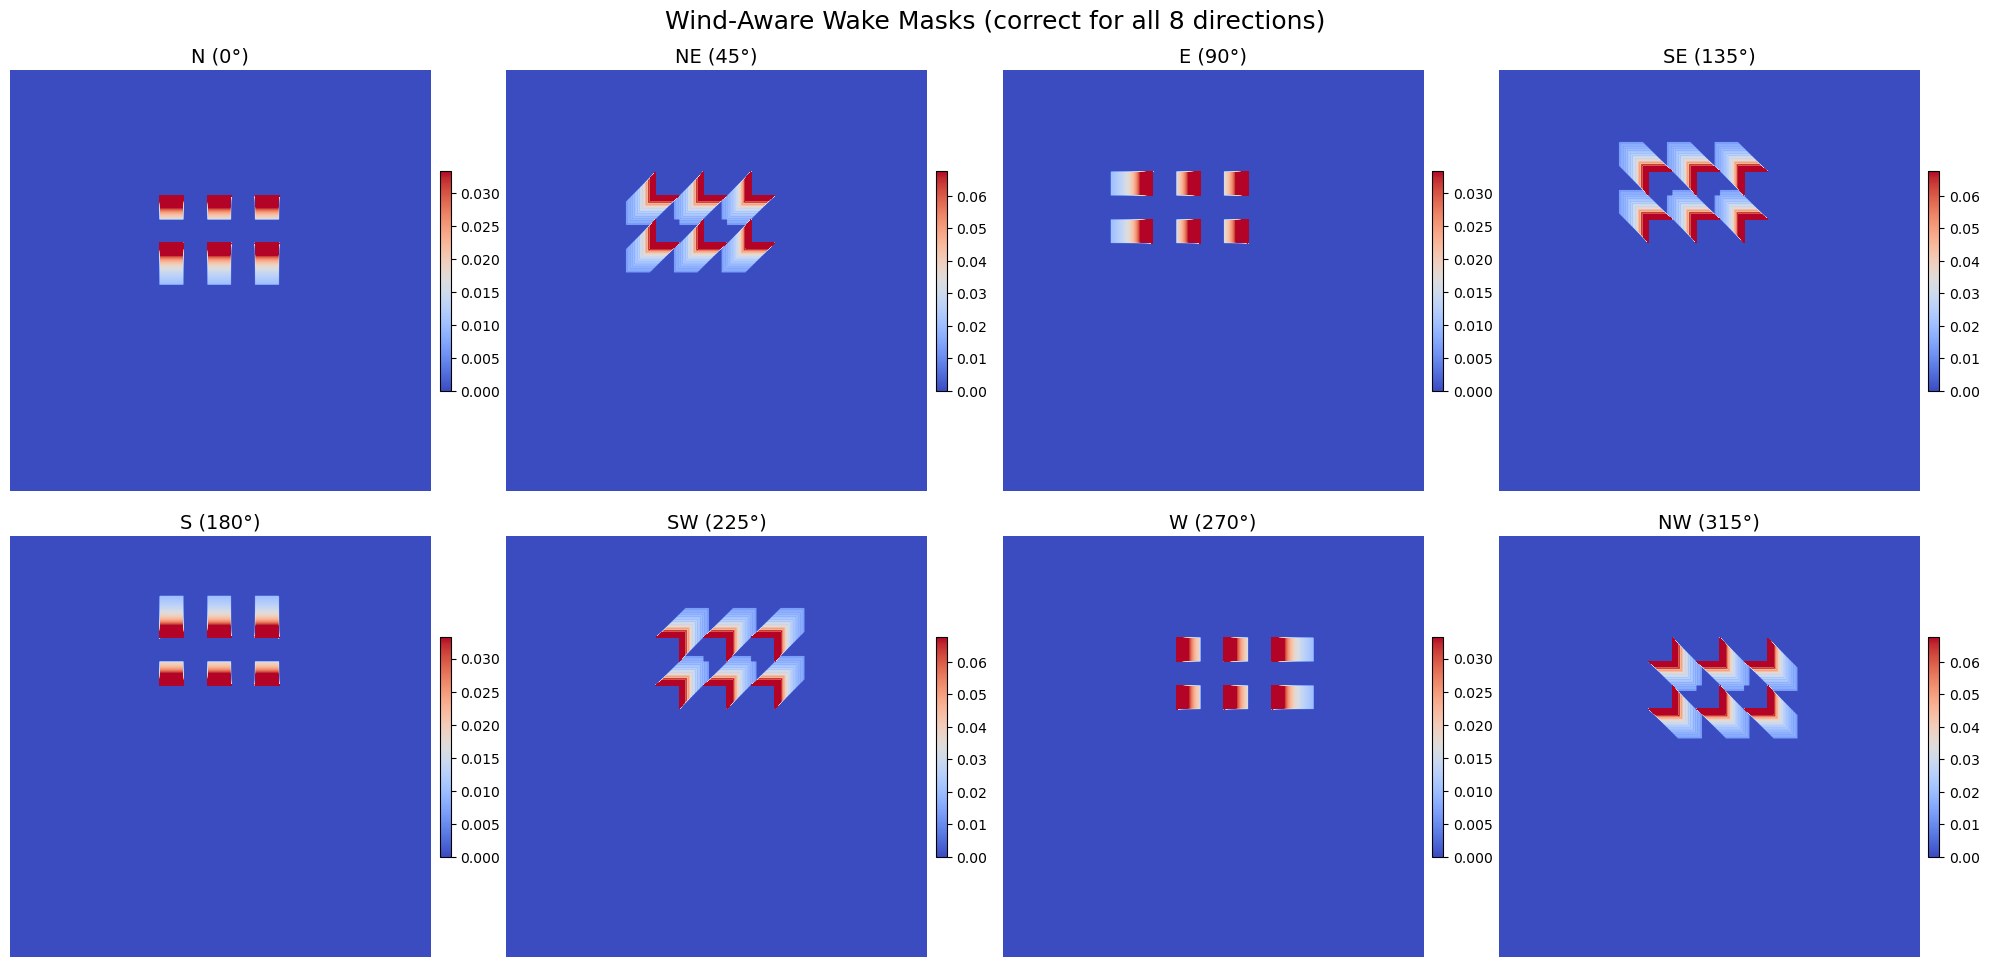

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
from pathlib import Path
import imageio.v2 as iio          # tiny PNG writer (already in most envs)

# ────────────────────────────────
# 1.  Load binary building mask
# ────────────────────────────────
mask_path = r"..\RawSimOutputData\6Bldgs\BldgMask150cm-BlackWhiteWithAntiAlias.png"
img_gray   = np.array(Image.open(mask_path).convert("L"))

# 1 = background, 0 = building
bg_mask       = (img_gray > 128).astype(np.uint8)
building_mask = ~bg_mask.astype(bool)

# ────────────────────────────────
# 2.  Pre‑compute inverse distance (optional)
# ────────────────────────────────
dist = cv2.distanceTransform(bg_mask, cv2.DIST_L2, 5)
inv_dist = 1.0 / (dist + 1e-6)
inv_dist[building_mask] = 0        # buildings stay zero

# ────────────────────────────────
# 2b. Save inverse distance mask
# ────────────────────────────────
distance_mask_dir = Path("../data/X/DistanceMask")
distance_mask_dir.mkdir(parents=True, exist_ok=True)

# Save as .npy for precision in training
np.save(distance_mask_dir / "inverse_distance_mask.npy", inv_dist)

# Optional: save as PNG (scaled 0‑255 for visualization)
inv_dist_norm = np.asarray(255 * inv_dist / (np.nanmax(inv_dist) + 1e-9), dtype=np.uint8)
iio.imwrite(distance_mask_dir / "inverse_distance_mask.png", inv_dist_norm)

print(f"✅ Inverse distance mask saved to {distance_mask_dir.resolve()}")

# ────────────────────────────────
# 3.  Wake‑mask generator
# ────────────────────────────────
def wake_mask(angle_deg, bmask, max_len=100):
    """
    angle_deg : meteorological wind direction (0° = from N, 90° = from E …)
    returns   : inverse‑distance wake mask (buildings kept at 0)
    """
    θ  = np.deg2rad(angle_deg)

    # 🔹  FIX  🔹  ───────────────────────────────────────────────────────────
    # wind blows *toward* (-sinθ , +cosθ) in image coordinates
    vx = -np.sin(θ)          # 90° (from E) →  vx = -1  (wake drawn leftward)
    vy =  np.cos(θ)          # 0°  (from N) →  vy = +1  (wake drawn downward)
    # ───────────────────────────────────────────────────────────────────────

    h, w     = bmask.shape
    wake_map = np.zeros((h, w), dtype=float)

    by, bx = np.where(bmask)
    for y0, x0 in zip(by, bx):
        for d in range(1, max_len):
            x = int(round(x0 + d * vx))
            y = int(round(y0 + d * vy))
            if 0 <= x < w and 0 <= y < h and not bmask[y, x]:
                wake_map[y, x] += 1.0 / (d + 1e-3)
            else:
                break

    wake_map[bmask] = 0
    return wake_map

# target folder: data/X/WindMask  (creates it if missing)
out_dir = Path("../data/X/WindMask")
out_dir.mkdir(parents=True, exist_ok=True)

# choose the on‑disk format
SAVE_AS_PNG = True          # False → save .npy instead

for angle in range(360):
    wake = wake_mask(angle, building_mask, max_len=100)

    # normalise to 0‑255 for a compact 8‑bit PNG (optional)
    if SAVE_AS_PNG:
        w_norm = np.asarray(255 * wake / (wake.max() + 1e-9), dtype=np.uint8)
        outfile = out_dir / f"windmask_{angle:03d}.png"
        iio.imwrite(outfile, w_norm)
    else:
        outfile = out_dir / f"windmask_{angle:03d}.npy"
        np.save(outfile, wake)

print(f"✅ 360 wake masks written to {out_dir.resolve()}")

# ────────────────────────────────
# 4.  Create & display masks for 8 wind directions
# ────────────────────────────────
angles  = [0, 45, 90, 135, 180, 225, 270, 315]
labels  = ["N (0°)", "NE (45°)", "E (90°)", "SE (135°)",
           "S (180°)", "SW (225°)", "W (270°)", "NW (315°)"]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for idx, (a, lab) in enumerate(zip(angles, labels)):
    wake = wake_mask(a, building_mask)
    ax   = axs[idx // 4, idx % 4]
    vmax = np.percentile(wake, 99) or 1e-6   # avoid zero vmax
    im   = ax.imshow(wake, cmap="coolwarm", vmin=0, vmax=vmax)
    ax.set_title(lab, fontsize=14);  ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)

plt.suptitle("Wind‑Aware Wake Masks (correct for all 8 directions)", fontsize=18)
plt.tight_layout();  plt.show()